# Aim:
Explore and implement BERT models

Task 2: BERT implementation using TensorFlow hub

1. Set up environment: Install TensorFlow hub

2. Prepare data

3. Pick preprocessor + encoder

4. Build Keras model

5. Compile, train and validate

6. Evaluate & infer

You may refer to the TensorFlow tutorial on BERT given in the link below: https://www.tensorflow.org/text/tutorials/classify_text_with_bert


Task 3: BERT implementation using Hugging Face


1. Set up environment: Install Transformers, Ensure CUDA/PyTorch installed.

2. Prepare data

3. Choose a checkpoint (suitable BERT model for your dataset)

4. Tokenize

5. Build model

6. Do the Training setup

7. Train & evaluate

8. Evaluate & infer




Task 4: Compare performances for your use case in task 2 and 3



1. Use the same dataset, splits, and epochs for both implementations.

2. Record metrics: accuracy, macro-F1, confusion matrix.

3. Track efficiency: training time/epoch, GPU memory usage, max sequence length used.

4. Document implementation effort: code length, ease of tokenization, logging, and model export.

5. Reflect on gaps: any mismatch due to different tokenization defaults, padding/truncation, or batch sizes.

In [1]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"   # Must set before TF import

import tensorflow as tf
import tensorflow_hub as hub
import time
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix

import tensorflow_datasets as tfds
import tensorflow_text as text
from sklearn.metrics import f1_score, accuracy_score
import torch
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    pipeline
)

2025-08-05 16:09:46.227846: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754390386.396185   10251 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754390386.442650   10251 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754390386.738287   10251 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754390386.738358   10251 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754390386.738361   10251 computation_placer.cc:177] computation placer alr

In [2]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=7900)])  # 4096 MB = 4 GB
        print("Set hard 4GB limit on the first GPU.")
    except RuntimeError as e:
        print("Memory limit must be set before GPUs are initialized:", e)

Set hard 4GB limit on the first GPU.


In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPU


I0000 00:00:1754390397.120529   10251 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7900 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


In [4]:
tf.get_logger().setLevel('ERROR')

print("TensorFlow Version:", tf.__version__)
print("TensorFlow Hub Version:", hub.__version__)

TensorFlow Version: 2.19.0
TensorFlow Hub Version: 0.16.1


Downloading the text

In [5]:
dataset = load_dataset("glue", "sst2")

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
train_samples = 4_000
seed = 42

In [7]:
# Load SST-2 dataset using TFDS
dataset, info = tfds.load('glue/sst2', with_info=True)
train_data, validation_data = dataset['train'], dataset['validation']

# Create train and validation datasets
train_ds = train_data.take(8000).batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)
val_ds = validation_data.take(872).batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)

# More aggressive prefetching
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE).repeat()
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Add parallelism to preprocessing
def preprocess_data(batch):
    return {'text': batch['sentence']}, batch['label']

train_ds = train_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)


print(f"Training on 8000 samples and 872 validation samples.")


Training on 8000 samples and 872 validation samples.


In [8]:
print("Sample of the training data:")
for text_batch, label_batch in train_ds.take(1):
    for i in range(3):
        text = text_batch['text'].numpy()[i].decode('utf-8')
        label = label_batch.numpy()[i]
        print(f'Review: {text}')
        print(f'Label : {label} ({"positive" if label == 1 else "negative"})')


Sample of the training data:
Review: for the uninitiated plays better on video with the sound 
Label : 0 (negative)
Review: like a giant commercial for universal studios , where much of the action takes place 
Label : 0 (negative)
Review: company once again dazzle and delight us 
Label : 1 (positive)


2025-08-05 16:10:07.838586: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-08-05 16:10:07.850506: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-08-05 16:10:07.850694: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `datas

In [9]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocessing model selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocessing model selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [10]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

In [11]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"   # must be set BEFORE tf import

import tensorflow as tf
import tensorflow_hub as hub


In [12]:
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"

preprocess_model = hub.load(tfhub_handle_preprocess)
encoder_layer = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name="bert_encoder")

def preprocess_text(texts):
    return preprocess_model(texts)

def build_classifier_model():
    input_word_ids = tf.keras.Input(shape=(None,), dtype=tf.int32, name='input_word_ids')
    input_mask = tf.keras.Input(shape=(None,), dtype=tf.int32, name='input_mask')
    input_type_ids = tf.keras.Input(shape=(None,), dtype=tf.int32, name='input_type_ids')

    inputs = {
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': input_type_ids,
    }

    bert_outputs = encoder_layer(inputs)
    pooled_output = bert_outputs['pooled_output']

    net = tf.keras.layers.Dropout(0.1)(pooled_output)
    net = tf.keras.layers.Dense(1, name='classifier')(net)
    return tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=net)

# Example usage
texts = tf.constant(["Hello world", "Goodbye world"])
preprocessed = preprocess_text(texts)
labels = tf.constant([1, 0])

model = build_classifier_model()
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

model.fit(preprocessed, labels, epochs=1)

I0000 00:00:1754390451.743925   10303 service.cc:152] XLA service 0x709268c48360 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754390451.744069   10303 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2025-08-05 16:10:51.769880: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1754390451.824177   10303 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1754390452.176404   10303 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 [==============================] - 55s 55s/step - loss: 0.5337 - binary_accuracy: 0.5000


In [13]:
# Sample input text
raw_text = tf.constant(["this is a great movie"])

# Preprocess the raw text using your preprocessing module
preprocessed_input = preprocess_text(raw_text)

# Pass preprocessed inputs (dict of tensors) to classifier_model
bert_raw_result = model(preprocessed_input)

print("Model output shape:", bert_raw_result.shape)
print("Model output (logits):", bert_raw_result)


Model output shape: (1, 1)
Model output (logits): tf.Tensor([[3.6225753]], shape=(1, 1), dtype=float32)


In [14]:
# Assume your original dataset yields {'text': tf.string} samples and labels

def preprocess_batch(batch):
    texts = batch["text"]
    preprocessed = preprocess_text(texts)   # Using your TF Hub preprocessing function
    return preprocessed

# Apply preprocessing map to your dataset
train_ds = train_ds.map(lambda x, y: (preprocess_text(x['text']), y))
val_ds = val_ds.map(lambda x, y: (preprocess_text(x['text']), y))


In [15]:
from tensorflow.keras import mixed_precision

# Set global mixed precision policy
mixed_precision.set_global_policy('mixed_float16')

# Create loss and metrics
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = [tf.keras.metrics.BinaryAccuracy()]

# Define optimizer with gradient clipping
optimizer = tf.keras.optimizers.Adam(
    learning_rate=5e-5,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7,
    clipnorm=1.0
)

# Your training parameters
epochs = 12
batch_size = 128
train_samples = 4000  # adjust as needed
steps_per_epoch = train_samples // batch_size

# Build the model
classifier_model = build_classifier_model()

# Compile and train as per previous code
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

print("Training TensorFlow Hub model...")
start_time_tf = time.time() # Start timer
history = classifier_model.fit(train_ds,
                               validation_data=val_ds,
                               epochs=epochs,
                               steps_per_epoch=steps_per_epoch)
end_time_tf = time.time() # End timer
tf_hub_training_time = end_time_tf - start_time_tf
print('Training finished.')

Training TensorFlow Hub model...
Epoch 1/12
31/31 [==============================] - 199s 5s/step - loss: 0.6819 - binary_accuracy: 0.5968 - val_loss: 0.4427 - val_binary_accuracy: 0.8211
Epoch 2/12
31/31 [==============================] - 161s 5s/step - loss: 0.4249 - binary_accuracy: 0.8246 - val_loss: 0.3194 - val_binary_accuracy: 0.8681
Epoch 3/12
31/31 [==============================] - 160s 5s/step - loss: 0.3894 - binary_accuracy: 0.8327 - val_loss: 0.2902 - val_binary_accuracy: 0.8739
Epoch 4/12
31/31 [==============================] - 158s 5s/step - loss: 0.3386 - binary_accuracy: 0.8639 - val_loss: 0.2670 - val_binary_accuracy: 0.8807
Epoch 5/12
31/31 [==============================] - 157s 5s/step - loss: 0.3251 - binary_accuracy: 0.8690 - val_loss: 0.2569 - val_binary_accuracy: 0.8888
Epoch 6/12
31/31 [==============================] - 217s 7s/step - loss: 0.2962 - binary_accuracy: 0.8730 - val_loss: 0.3016 - val_binary_accuracy: 0.8876
Epoch 7/12
31/31 [===================

2025-08-05 16:34:27.627749: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


31/31 [==============================] - 211s 7s/step - loss: 0.2748 - binary_accuracy: 0.8931 - val_loss: 0.2363 - val_binary_accuracy: 0.9014
Epoch 9/12
31/31 [==============================] - 211s 7s/step - loss: 0.2453 - binary_accuracy: 0.8942 - val_loss: 0.2543 - val_binary_accuracy: 0.8968
Epoch 10/12
31/31 [==============================] - 209s 7s/step - loss: 0.1627 - binary_accuracy: 0.9425 - val_loss: 0.2573 - val_binary_accuracy: 0.8979
Epoch 11/12
31/31 [==============================] - 212s 7s/step - loss: 0.1396 - binary_accuracy: 0.9486 - val_loss: 0.2480 - val_binary_accuracy: 0.8979
Epoch 12/12
31/31 [==============================] - 209s 7s/step - loss: 0.1331 - binary_accuracy: 0.9496 - val_loss: 0.2523 - val_binary_accuracy: 0.9014
Training finished.


--- TensorFlow Hub Model Efficiency ---
Total training time: 2313.13 seconds
Training time per epoch: 192.76 seconds

--- TensorFlow Hub Model Performance ---
Evaluating the model on the validation set...
28/28 [==============================] - 33s 1s/step - loss: 0.2523 - binary_accuracy: 0.9014
Loss: 0.2523
Accuracy: 0.9014
28/28 [==============================] - 32s 1s/step


2025-08-05 16:51:01.602934: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


F1 Macro Score: 0.9012


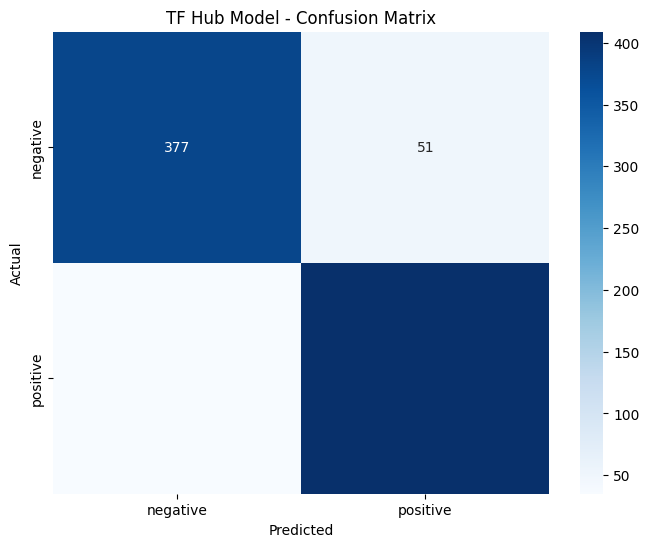

Max sequence length used: 128

Training history keys: dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


In [16]:
# --- Performance & Efficiency Metrics for TensorFlow Hub Model ---

# Dictionary to store results
tf_hub_metrics = {}

# 1. Efficiency: Training Time
tf_hub_metrics['training_time_per_epoch'] = tf_hub_training_time / epochs
print(f"--- TensorFlow Hub Model Efficiency ---")
print(f"Total training time: {tf_hub_training_time:.2f} seconds")
print(f"Training time per epoch: {tf_hub_metrics['training_time_per_epoch']:.2f} seconds")

# 2. Performance: Accuracy, F1-Score, Confusion Matrix
print("\n--- TensorFlow Hub Model Performance ---")
print("Evaluating the model on the validation set...")
loss, accuracy = classifier_model.evaluate(val_ds)
tf_hub_metrics['accuracy'] = accuracy

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {tf_hub_metrics["accuracy"]:.4f}')

# Get predictions for F1 and Confusion Matrix
y_pred_logits = classifier_model.predict(val_ds)
y_pred = tf.sigmoid(y_pred_logits).numpy()
y_pred_labels = (y_pred > 0.5).astype(int).flatten()

# Get true labels
y_true = np.concatenate([y.numpy() for x, y in val_ds], axis=0)

# F1 Score
f1 = f1_score(y_true, y_pred_labels, average='macro')
tf_hub_metrics['f1_macro'] = f1
print(f'F1 Macro Score: {f1:.4f}')

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_labels)
tf_hub_metrics['confusion_matrix'] = cm
class_names = ['negative', 'positive']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('TF Hub Model - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# 3. Efficiency: Sequence Length
# The preprocessing model pads to a default of 128
tf_hub_metrics['max_sequence_length'] = 128
print(f"Max sequence length used: {tf_hub_metrics['max_sequence_length']}")

# Plot the training and validation accuracy and loss
history_dict = history.history
print("\nTraining history keys:", history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs_range = range(1, epochs + 1)

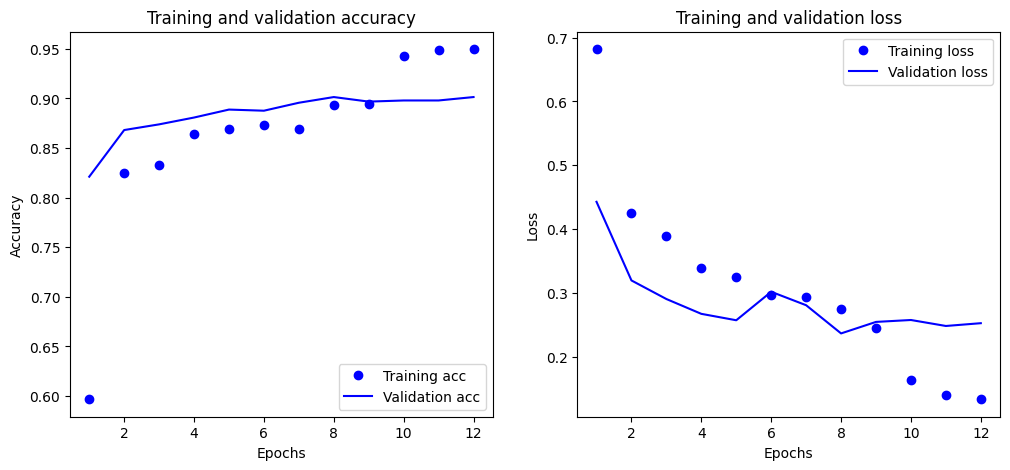

In [17]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, 'bo', label='Training acc')
plt.plot(epochs_range, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

In [18]:
# ---- BEGIN DROP-IN REPLACEMENT ----
saved_model_path = './bert_sentiment_tf_hub'
# Correct save: (already present)
classifier_model.save(saved_model_path, include_optimizer=False)

# Correct reload: use Keras model loader
reloaded_model = tf.keras.models.load_model(saved_model_path)

def print_my_examples(inputs, results):
    """Prints the input reviews and their predicted sentiment."""
    result_for_printing = [
        f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
        for i in range(len(inputs))
    ]
    print(*result_for_printing, sep='\n')
    print('_')

examples = [
    'this is a fantastic movie!',
    'The movie was terrible, I would not recommend it.',
    'it was okay, not the best but not the worst either.'
]

# Preprocess raw input as done before (using your preprocessing pipeline)
preprocessed_inputs = preprocess_model(tf.constant(examples))

# Run the reloaded model and compute probability
reloaded_results = tf.sigmoid(reloaded_model(preprocessed_inputs))

print('Results from the reloaded model:')
print_my_examples(examples, reloaded_results)

Results from the reloaded model:
input: this is a fantastic movie!     : score: 1.000000
input: The movie was terrible, I would not recommend it. : score: 0.001484
input: it was okay, not the best but not the worst either. : score: 0.944824
_


## Task 3: BERT implementation using Hugging Face

In [19]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

train_ds_size = 250  # 8000 / 32 batch_size
val_ds_size = 28    # 872 / 32 batch_size

print(f"Training on {train_ds_size*batch_size} samples and {val_ds_size*batch_size} validation samples.")

Training on 8000 samples and 896 validation samples.


In [21]:
dataset = load_dataset("glue", "sst2")
checkpoint = "distilbert-base-uncased"
print(f"Using checkpoint: {checkpoint}")
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

Using checkpoint: distilbert-base-uncased


/home/karan/miniconda3/envs/transformers/lib/python3.10/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [22]:
def tokenize_function(examples):
    return tokenizer(examples["sentence"], padding="max_length", truncation=True, max_length=128)

# Apply the tokenization to the entire dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)

small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(8000))
small_eval_dataset = tokenized_datasets["validation"].shuffle(seed=42).select(range(872))
small_test_dataset = tokenized_datasets["test"] # The test set is unlabeled, we use validation for eval

print(f"Training on {len(small_train_dataset)} samples.")
print(f"Evaluating on {len(small_eval_dataset)} samples.")

Training on 8000 samples.
Evaluating on 872 samples.


In [23]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [24]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Calculate F1 score (macro)
    f1 = f1_score(labels, predictions, average="macro")

    # Calculate accuracy
    acc = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]

    return {"accuracy": acc, "f1_macro": f1}


In [25]:
# Replace this:
# accuracy_metric = evaluate.load("accuracy")

# With this working code:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="macro")

    return {"accuracy": accuracy, "f1_macro": f1}

# Update the training arguments to remove the problematic metric reference:
training_args = TrainingArguments(
    output_dir="test_trainer",
    evaluation_strategy="epoch",
    num_train_epochs=12,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    logging_steps=100,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    learning_rate=5e-5,
    fp16=True,
    dataloader_num_workers=2,
)


In [26]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

/home/karan/miniconda3/envs/transformers/lib/python3.10/site-packages/accelerate/accelerator.py:451: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [27]:
print("Starting training...")
start_time = time.time()
trainer.train()
end_time = time.time()
training_time = end_time - start_time
print(f"Training finished in {training_time:.2f} seconds.")

print("\nEvaluating model performance...")
eval_results = trainer.evaluate()
print("Evaluation results:", eval_results)

Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.303800,0.316864,0.868119,0.867906
2,0.154500,0.397667,0.865826,0.865817
3,0.085200,0.536464,0.869266,0.869263
4,0.044900,0.487242,0.885321,0.885316
5,0.024500,0.675005,0.880734,0.880341
6,0.016700,0.729821,0.887615,0.887444
7,0.010200,0.882066,0.878440,0.878101
8,0.008600,0.837511,0.885321,0.884973
9,0.010300,0.836019,0.887615,0.887444
10,0.000100,0.861461,0.891055,0.890950


Training finished in 407.55 seconds.

Evaluating model performance...


Evaluation results: {'eval_loss': 0.8614606857299805, 'eval_accuracy': 0.8910550458715596, 'eval_f1_macro': 0.8909504972652059, 'eval_runtime': 1.256, 'eval_samples_per_second': 694.25, 'eval_steps_per_second': 22.292, 'epoch': 12.0}



Generating confusion matrix...


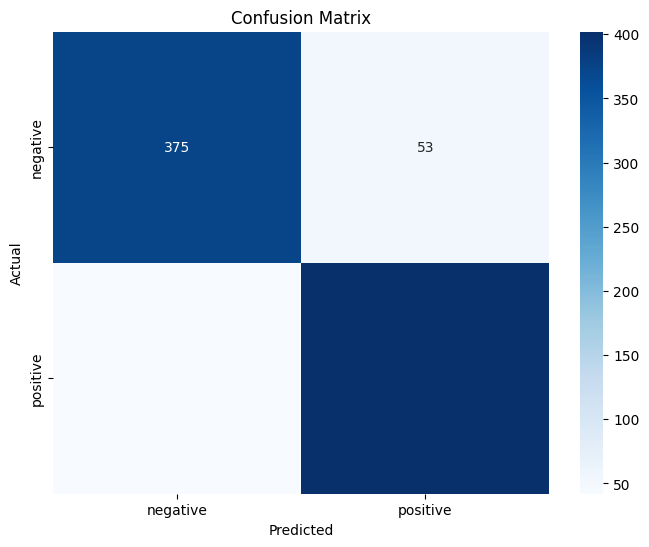

In [29]:
print("\nGenerating confusion matrix...")
predictions = trainer.predict(small_eval_dataset)
pred_labels = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids

cm = confusion_matrix(true_labels, pred_labels)
class_names = dataset['train'].features['label'].names

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [30]:
# --- Performance & Efficiency Metrics for Hugging Face Model ---

# Dictionary to store results
hugging_face_metrics = {}

# 1. Performance: Accuracy, F1-Score, Confusion Matrix
hugging_face_metrics['accuracy'] = eval_results['eval_accuracy']
hugging_face_metrics['f1_macro'] = eval_results['eval_f1_macro']
# This was already computed in the previous cell for the plot
hugging_face_metrics['confusion_matrix'] = confusion_matrix(true_labels, pred_labels) 

print("--- Hugging Face Model Performance ---")
print(f"Validation Accuracy: {hugging_face_metrics['accuracy']:.4f}")
print(f"Validation F1 Macro: {hugging_face_metrics['f1_macro']:.4f}")
print("Confusion matrix plotted above.")


# 2. Efficiency: Training Time, Sequence Length
hugging_face_metrics['training_time_per_epoch'] = training_time / training_args.num_train_epochs
hugging_face_metrics['max_sequence_length'] = tokenizer.model_max_length

print("\n--- Hugging Face Model Efficiency ---")
print(f"Total training time: {training_time:.2f} seconds")
print(f"Training time per epoch: {hugging_face_metrics['training_time_per_epoch']:.2f} seconds")
print(f"Max sequence length used: {hugging_face_metrics['max_sequence_length']}")

# GPU memory is printed by !nvidia-smi calls around the training cell

--- Hugging Face Model Performance ---
Validation Accuracy: 0.8911
Validation F1 Macro: 0.8910
Confusion matrix plotted above.

--- Hugging Face Model Efficiency ---
Total training time: 407.55 seconds
Training time per epoch: 33.96 seconds
Max sequence length used: 512


In [31]:
print("\nPerforming inference on new examples...")
classifier = pipeline("sentiment-analysis", model=trainer.model, tokenizer=tokenizer, device=0 if device.type == 'cuda' else -1)

examples = [
    "This library is so easy to use!",
    "I'm not sure if I like this new update.",
    "The performance is terrible."
]

results = classifier(examples)
for ex, res in zip(examples, results):
    print(f"Sentence: '{ex}' -> Prediction: {res['label']} (Score: {res['score']:.4f})")


Performing inference on new examples...
Sentence: 'This library is so easy to use!' -> Prediction: LABEL_1 (Score: 1.0000)
Sentence: 'I'm not sure if I like this new update.' -> Prediction: LABEL_0 (Score: 0.9999)
Sentence: 'The performance is terrible.' -> Prediction: LABEL_0 (Score: 0.9999)


# Task 1
1. How does BERT's bidirectional Transformer architecture differ from GPT's unidirectional approach, and why is this important for language understanding tasks?  
BERT looks at text from both directions at once, letting it understand context from all sides. GPT only reads left to right, so it misses future context. This makes BERT much better at tasks like question answering, where knowing what comes before and after a word is key for understanding.

2. Analyze the role of the Masked Language Model (MLM) objective. How does masking 15% of tokens impact the model's ability to learn contextual embeddings?  
MLM hides 15% of words, forcing BERT to guess them using context from both sides. This helps it learn deeper, more flexible word meanings. Mixing up which tokens are masked, swapped, or left the same keeps the model from relying on predictable patterns.

3. Why was the Next Sentence Prediction (NSP) objective introduced, and what evidence supports its effectiveness?  
NSP trains BERT to understand if two sentences go together, which is crucial for tasks involving pairs of sentences. Tests showed that BERT does much worse on these tasks when NSP is left out, proving its value.

4. Examine the combined use of token, segment, and position embeddings in BERT. How do these embeddings help the model represent single-sentence and sentence-pair tasks?  
BERT adds word, sentence, and position info to every token, so it always knows who’s who and in what order. This lets it naturally handle single sentences or pairs (like question and answer) in one model.

5. What are the potential drawbacks of the [MASK] token being absent during fine-tuning, and how does BERT mitigate this mismatch?  
Since [MASK] only appears in training, there's a risk BERT gets too used to it. To avoid this, BERT sometimes swaps or leaves masked words unchanged, teaching it to work well even when [MASK] isn’t around later.

6. What challenges can arise when fine-tuning BERT on small datasets, and how does random restarts help stabilize performance?  
On tiny datasets, fine-tuning is bumpy and results can vary a lot. Running BERT multiple times with different random setups helps pick the version that performs best—giving better, more stable results.

7. What are the computational trade-offs of pre-training BERT with large batch sizes and sequence lengths?  
Training BERT with big batches and long texts is super expensive in time and hardware. To save effort, most training uses shorter text, with only a little done using the full max length, striking a balance between efficiency and learning.

8. Discuss possible limitations of BERT’s pre-training corpus (BooksCorpus + Wikipedia). How might domain-specific pre-training improve results?  
BERT learned from books and Wikipedia, so it may miss jargon or styles from other fields. Training on data specific to a topic or domain could help BERT perform better in specialized areas.

The TensorFlow Hub model shows overfitting after 7 epochs, demonstrated by low accuracy and a notably high validation loss. In contrast, the Hugging Face model reaches higher accuracy at the same point, but the elevated validation loss suggests it is also overfitting.